In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski, Fragments, rdmolops
from rdkit.ML.Cluster import Butina

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# *IF FEATURE ENGINEERING IS DONE: DO NOT START HERE*
# *SKIP TO THE START OF SECTION IV: MODEL SELECTION*

# I. Exploratory Data Analysis

In [2]:
# Read in training data
df_train = pd.read_csv("train.csv")


In [3]:
df_train.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256,gap
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.19
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1.60
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.49
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.36
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.98


(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.30000000e+01,
          2.08000000e+02,   1.87700000e+03,   6.97100000e+03,
          1.85790000e+04,   3.26720000e+04,   4.29330000e+04,
          6.01070000e+04,   6.78140000e+04,   8.81420000e+04,
          8.71470000e+04,   1.00516000e+05,   8.87370000e+04,
          9.22500000e+04,   7.71080000e+04,   7.28620000e+04,
          5.39310000e+04,   4.40760000e+04,   2.65580000e+04,
          1.79800000e+04,   9.49400000e+03,   5.73300000e+03,
          2.40600000e+03,   1.27500000e+03,   4.13000000e+02,
          1.57000000e+02,   2.40000000e+01,   9.00000000e+00,
        

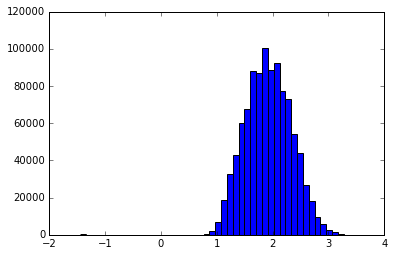

In [4]:
plt.hist(df_train.gap.values, bins=50)

### Note: 
I see some outliers around -1.5.  Having negative values makes no sense, since the gap is highest - lowest -- they must be misrecorded.  ==> Remove them

In [5]:
# Remove negative HOMO-LUMO gaps
df_train = df_train[df_train['gap'] >= 0]

In [6]:
print len(df_train)

999997


(array([  1.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          6.80000000e+01,   3.46000000e+02,   1.03000000e+03,
          3.10900000e+03,   5.69200000e+03,   1.16800000e+04,
          1.52310000e+04,   2.31510000e+04,   2.45190000e+04,
          2.82990000e+04,   3.82210000e+04,   3.75660000e+04,
          4.99490000e+04,   4.69370000e+04,   5.92430000e+04,
          5.27070000e+04,   6.31800000e+04,   5.51100000e+04,
          6.23660000e+04,   5.13550000e+04,   5.81940000e+04,
          4.73270000e+04,   4.41680000e+04,   4.62780000e+04,
          3.57430000e+04,   3.51520000e+04,   2.52700000e+04,
          2.32420000e+04,   1.51640000e+04,   1.31150000e+04,
          8.26600000e+03,   6.79300000e+03,   4.05100000e+03,
          3.17300000e+03,   1.67100000e+03,   1.03700000e+03,
          7.96000000e+02,   3.72000000e+02,   2.42000000e+02,
          9.00000000e+01,   5.30000000e+01,   1.40000000e+01,
          6.00000000e+00,   3.00000000e+00,   3.00000000e+00,
        

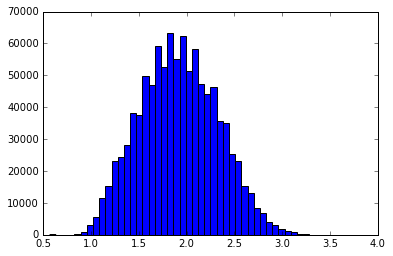

In [7]:
# Plot histogram of gaps without negative values
plt.hist(df_train.gap.values, bins=50)

# II. Training Data Processing and Feature Engineering
1. Drop all columns except smiles and gaps
2. Add "key" column, partition the data, and save those partitions
3. Remove all dataframes from memory
4. Load each partition (1 by 1), perform feature engineering, and save each partition to a csv
5. Reaggregate all partitions into one df, merge add binary-valued features from original training dataset, and save to csv

### 1. Drop all columns except smiles and gaps

In [8]:
# remove all columns except smiles and gaps
df_train = df_train.drop(df_train.columns[range(1,257)], axis=1)
df_train.head()

,smiles,gap
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,1.19
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1.60
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1.49
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1.36
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,1.98


### 2. Add "key" column, partition the data, and save those partitions

In [9]:
# add key column
df_train['key'] = df_train.index

In [10]:
df_train.head()

,smiles,gap,key
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,1.19,0
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1.60,1
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1.49,2
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1.36,3
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,1.98,4


In [11]:
num_parts = 10
df_train_parts = np.array_split(df_train, num_parts)
for i in xrange(len(df_train_parts)):
    df_train_parts[i].to_csv('smiles_gaps_keys_df_train_part_'+str(i)+'.csv', index=False)

### 3. Remove all dataframes from memory

In [12]:
del df_train
del df_train_parts

### 4. Load each partition (1 by 1), perform feature engineering, and save each partition to a csv

(http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). 

#### Number of Branches
The idea is that the number of  [branches](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#Branching) influences the gap between HOMO and LUMO levels.

#### Note: We pull the specific compounds of intereste from [this poster.](http://digitalscholarship.unlv.edu/cgi/viewcontent.cgi?article=1036&context=focs_ug_research)

#### Benzene Ring
The last feature is determining, from the SMILES encoding whether or not there is a benzene ring in the compound. Benzene rings are held together with pi bonds which are more conjugated (which means they are closer together in energy)

#### Number of Double Bonds

#### Additional Features engineered using from RDKit library

In [14]:
for i in xrange(num_parts):
    df_train_part = pd.read_csv('smiles_gaps_keys_df_train_part_'+str(i)+'.csv')
    
    # Apply feature engineering to train data
    num_branches = df_train_part.smiles.apply(lambda x: x.count('('))
    has_benzothiophene = df_train_part.smiles.apply(lambda x: min(1,x.count('s2c1ccccc1cc2')))
    has_carbazole = df_train_part.smiles.apply(lambda x: min(1,x.count('c1ccc2c(c1)c3ccccc3[nH]2')))
    has_fluorene = df_train_part.smiles.apply(lambda x: min(1,x.count('c1ccc-2c(c1)Cc3c2cccc3')))
    num_double_bonds = df_train_part.smiles.apply(lambda x: x.count('='))
    df_train_part['num_branches'] = num_branches
    df_train_part['has_benzothiophene'] = has_benzothiophene
    df_train_part['has_carbazole'] = has_carbazole
    df_train_part['has_fluorene'] = has_fluorene
    df_train_part['num_double_bonds'] = num_double_bonds
    print "Part {}: finished initial feat gen".format(i)
    # RDKit Feature Engineering
    # Generate molecule objects
    molecules = df_train_part.smiles.apply(lambda x: Chem.MolFromSmiles(x))
    print "Part {}: finished molecule generation".format(i)
    # Generate Features
    df_train_part['avg_molecular_weight'] = molecules.apply(lambda x: Descriptors.MolWt(x))
    print "Part {}: finished first feature".format(i)
    df_train_part['exact_molecular_weight'] = molecules.apply(lambda x: Descriptors.ExactMolWt(x))
    df_train_part['avg_molecular_weight_ignore_hydrogen'] = molecules.apply(lambda x: Descriptors.HeavyAtomMolWt(x))
    df_train_part['num_valence_electrons'] = molecules.apply(lambda x: Descriptors.NumValenceElectrons(x))
    df_train_part['num_radical_electrons'] = molecules.apply(lambda x: Descriptors.NumRadicalElectrons(x))
    df_train_part['formal_charge'] = molecules.apply(lambda x: rdmolops.GetFormalCharge(x))
    df_train_part['sssr'] = molecules.apply(lambda x: rdmolops.GetSSSR(x))
    print "Part {}: finished Descriptors and rdmolops".format(i)
    df_train_part['fraction_csp3'] = molecules.apply(lambda x: Lipinski.FractionCSP3(x))
    df_train_part['num_aliphatic_carbocycles'] = molecules.apply(lambda x: Lipinski.NumAliphaticCarbocycles(x))
    df_train_part['num_aliphatic_heterocycles'] = molecules.apply(lambda x: Lipinski.NumAliphaticHeterocycles(x))
    df_train_part['num_aliphatic_rings'] = molecules.apply(lambda x: Lipinski.NumAliphaticRings(x))
    df_train_part['num_aromatic_carbocycles'] = molecules.apply(lambda x: Lipinski.NumAromaticCarbocycles(x))
    df_train_part['num_aromatic_heterocycles'] = molecules.apply(lambda x: Lipinski.NumAromaticHeterocycles(x))
    df_train_part['num_aromatic_rings'] = molecules.apply(lambda x: Lipinski.NumAromaticRings(x))
    df_train_part['num_saturated_carbocycles'] = molecules.apply(lambda x: Lipinski.NumSaturatedCarbocycles(x))
    df_train_part['num_saturated_heterocycles'] = molecules.apply(lambda x: Lipinski.NumSaturatedHeterocycles(x))
    df_train_part['num_saturated_rings'] = molecules.apply(lambda x: Lipinski.NumSaturatedRings(x))
    df_train_part['num_nh_oh'] = molecules.apply(lambda x: Lipinski.NHOHCount(x))
    df_train_part['num_num_rotatable_bonds'] = molecules.apply(lambda x: Lipinski.NumRotatableBonds(x))
    df_train_part['num_heteroatoms'] = molecules.apply(lambda x: Lipinski.NumHeteroatoms(x))
    df_train_part['num_h_acceptors'] = molecules.apply(lambda x: Lipinski.NumHAcceptors(x))
    df_train_part['num_h_donors'] = molecules.apply(lambda x: Lipinski.NumHDonors(x))
    df_train_part['ring_count'] = molecules.apply(lambda x: Lipinski.RingCount(x))
    print "Part {}: finished Lipinski".format(i)
    # See Parsing_methods_from_rdk_source.ipynb
    df_train_part['fr_Al_COO'] = molecules.apply(lambda x: Fragments.fr_Al_COO(x))
    df_train_part['fr_Al_OH'] = molecules.apply(lambda x: Fragments.fr_Al_OH(x))
    df_train_part['fr_Al_OH_noTert'] = molecules.apply(lambda x: Fragments.fr_Al_OH_noTert(x))
    df_train_part['fr_ArN'] = molecules.apply(lambda x: Fragments.fr_ArN(x))
    df_train_part['fr_Ar_COO'] = molecules.apply(lambda x: Fragments.fr_Ar_COO(x))
    df_train_part['fr_Ar_N'] = molecules.apply(lambda x: Fragments.fr_Ar_N(x))
    df_train_part['fr_Ar_NH'] = molecules.apply(lambda x: Fragments.fr_Ar_NH(x))
    df_train_part['fr_Ar_OH'] = molecules.apply(lambda x: Fragments.fr_Ar_OH(x))
    df_train_part['fr_COO'] = molecules.apply(lambda x: Fragments.fr_COO(x))
    df_train_part['fr_COO2'] = molecules.apply(lambda x: Fragments.fr_COO2(x))
    df_train_part['fr_C_O'] = molecules.apply(lambda x: Fragments.fr_C_O(x))
    df_train_part['fr_C_O_noCOO'] = molecules.apply(lambda x: Fragments.fr_C_O_noCOO(x))
    df_train_part['fr_C_S'] = molecules.apply(lambda x: Fragments.fr_C_S(x))
    df_train_part['fr_HOCCN'] = molecules.apply(lambda x: Fragments.fr_HOCCN(x))
    df_train_part['fr_Imine'] = molecules.apply(lambda x: Fragments.fr_Imine(x))
    df_train_part['fr_NH0'] = molecules.apply(lambda x: Fragments.fr_NH0(x))
    df_train_part['fr_NH1'] = molecules.apply(lambda x: Fragments.fr_NH1(x))
    df_train_part['fr_NH2'] = molecules.apply(lambda x: Fragments.fr_NH2(x))
    df_train_part['fr_N_O'] = molecules.apply(lambda x: Fragments.fr_N_O(x))
    df_train_part['fr_Ndealkylation1'] = molecules.apply(lambda x: Fragments.fr_Ndealkylation1(x))
    df_train_part['fr_Ndealkylation2'] = molecules.apply(lambda x: Fragments.fr_Ndealkylation2(x))
    df_train_part['fr_Nhpyrrole'] = molecules.apply(lambda x: Fragments.fr_Nhpyrrole(x))
    df_train_part['fr_SH'] = molecules.apply(lambda x: Fragments.fr_SH(x))
    df_train_part['fr_aldehyde'] = molecules.apply(lambda x: Fragments.fr_aldehyde(x))
    df_train_part['fr_alkyl_carbamate'] = molecules.apply(lambda x: Fragments.fr_alkyl_carbamate(x))
    df_train_part['fr_alkyl_halide'] = molecules.apply(lambda x: Fragments.fr_alkyl_halide(x))
    df_train_part['fr_allylic_oxid'] = molecules.apply(lambda x: Fragments.fr_allylic_oxid(x))
    df_train_part['fr_amide'] = molecules.apply(lambda x: Fragments.fr_amide(x))
    df_train_part['fr_amidine'] = molecules.apply(lambda x: Fragments.fr_amidine(x))
    df_train_part['fr_aniline'] = molecules.apply(lambda x: Fragments.fr_aniline(x))
    df_train_part['fr_aryl_methyl'] = molecules.apply(lambda x: Fragments.fr_aryl_methyl(x))
    df_train_part['fr_azide'] = molecules.apply(lambda x: Fragments.fr_azide(x))
    df_train_part['fr_azo'] = molecules.apply(lambda x: Fragments.fr_azo(x))
    df_train_part['fr_barbitur'] = molecules.apply(lambda x: Fragments.fr_barbitur(x))
    df_train_part['fr_benzene'] = molecules.apply(lambda x: Fragments.fr_benzene(x))
    df_train_part['fr_benzodiazepine'] = molecules.apply(lambda x: Fragments.fr_benzodiazepine(x))
    df_train_part['fr_bicyclic'] = molecules.apply(lambda x: Fragments.fr_bicyclic(x))
    df_train_part['fr_diazo'] = molecules.apply(lambda x: Fragments.fr_diazo(x))
    df_train_part['fr_dihydropyridine'] = molecules.apply(lambda x: Fragments.fr_dihydropyridine(x))
    df_train_part['fr_epoxide'] = molecules.apply(lambda x: Fragments.fr_epoxide(x))
    df_train_part['fr_ester'] = molecules.apply(lambda x: Fragments.fr_ester(x))
    df_train_part['fr_ether'] = molecules.apply(lambda x: Fragments.fr_ether(x))
    df_train_part['fr_furan'] = molecules.apply(lambda x: Fragments.fr_furan(x))
    df_train_part['fr_guanido'] = molecules.apply(lambda x: Fragments.fr_guanido(x))
    df_train_part['fr_halogen'] = molecules.apply(lambda x: Fragments.fr_halogen(x))
    df_train_part['fr_hdrzine'] = molecules.apply(lambda x: Fragments.fr_hdrzine(x))
    df_train_part['fr_hdrzone'] = molecules.apply(lambda x: Fragments.fr_hdrzone(x))
    df_train_part['fr_imidazole'] = molecules.apply(lambda x: Fragments.fr_imidazole(x))
    df_train_part['fr_imide'] = molecules.apply(lambda x: Fragments.fr_imide(x))
    df_train_part['fr_isocyan'] = molecules.apply(lambda x: Fragments.fr_isocyan(x))
    df_train_part['fr_isothiocyan'] = molecules.apply(lambda x: Fragments.fr_isothiocyan(x))
    df_train_part['fr_ketone'] = molecules.apply(lambda x: Fragments.fr_ketone(x))
    df_train_part['fr_lactam'] = molecules.apply(lambda x: Fragments.fr_lactam(x))
    df_train_part['fr_lactone'] = molecules.apply(lambda x: Fragments.fr_lactone(x))
    df_train_part['fr_methoxy'] = molecules.apply(lambda x: Fragments.fr_methoxy(x))
    df_train_part['fr_morpholine'] = molecules.apply(lambda x: Fragments.fr_morpholine(x))
    df_train_part['fr_nitrile'] = molecules.apply(lambda x: Fragments.fr_nitrile(x))
    df_train_part['fr_nitro'] = molecules.apply(lambda x: Fragments.fr_nitro(x))
    df_train_part['fr_nitro_arom'] = molecules.apply(lambda x: Fragments.fr_nitro_arom(x))
    df_train_part['fr_nitro_arom_nonortho'] = molecules.apply(lambda x: Fragments.fr_nitro_arom_nonortho(x))
    df_train_part['fr_nitroso'] = molecules.apply(lambda x: Fragments.fr_nitroso(x))
    df_train_part['fr_oxazole'] = molecules.apply(lambda x: Fragments.fr_oxazole(x))
    df_train_part['fr_oxime'] = molecules.apply(lambda x: Fragments.fr_oxime(x))
    df_train_part['fr_para_hydroxylation'] = molecules.apply(lambda x: Fragments.fr_para_hydroxylation(x))
    df_train_part['fr_phenol'] = molecules.apply(lambda x: Fragments.fr_phenol(x))
    df_train_part['fr_phenol_noOrthoHbond'] = molecules.apply(lambda x: Fragments.fr_phenol_noOrthoHbond(x))
    df_train_part['fr_phos_acid'] = molecules.apply(lambda x: Fragments.fr_phos_acid(x))
    df_train_part['fr_phos_ester'] = molecules.apply(lambda x: Fragments.fr_phos_ester(x))
    df_train_part['fr_piperdine'] = molecules.apply(lambda x: Fragments.fr_piperdine(x))
    df_train_part['fr_piperzine'] = molecules.apply(lambda x: Fragments.fr_piperzine(x))
    df_train_part['fr_priamide'] = molecules.apply(lambda x: Fragments.fr_priamide(x))
    df_train_part['fr_prisulfonamd'] = molecules.apply(lambda x: Fragments.fr_prisulfonamd(x))
    df_train_part['fr_pyridine'] = molecules.apply(lambda x: Fragments.fr_pyridine(x))
    df_train_part['fr_quatN'] = molecules.apply(lambda x: Fragments.fr_quatN(x))
    df_train_part['fr_sulfide'] = molecules.apply(lambda x: Fragments.fr_sulfide(x))
    df_train_part['fr_sulfonamd'] = molecules.apply(lambda x: Fragments.fr_sulfonamd(x))
    df_train_part['fr_sulfone'] = molecules.apply(lambda x: Fragments.fr_sulfone(x))
    df_train_part['fr_term_acetylene'] = molecules.apply(lambda x: Fragments.fr_term_acetylene(x))
    df_train_part['fr_tetrazole'] = molecules.apply(lambda x: Fragments.fr_tetrazole(x))
    df_train_part['fr_thiazole'] = molecules.apply(lambda x: Fragments.fr_thiazole(x))
    df_train_part['fr_thiocyan'] = molecules.apply(lambda x: Fragments.fr_thiocyan(x))
    df_train_part['fr_thiophene'] = molecules.apply(lambda x: Fragments.fr_thiophene(x))
    df_train_part['fr_unbrch_alkane'] = molecules.apply(lambda x: Fragments.fr_unbrch_alkane(x))
    df_train_part['fr_urea'] = molecules.apply(lambda x: Fragments.fr_urea(x))
    df_train_part['fr_ketone_Topliss'] = molecules.apply(lambda x: Fragments.fr_ketone_Topliss(x))
    
    print "Part {}: finished Fragments".format(i)
    df_train_part.to_csv('rdk_feat_eng_df_train_part_'+str(i)+'.csv', index=False)
    del df_train_part
    del molecules

Part 0: finished initial feat gen
Part 0: finished molecule generation
Part 0: finished first feature
Part 0: finished Descriptors and rdmolops
Part 0: finished Lipinski
Part 0: finished Fragments
Part 1: finished initial feat gen
Part 1: finished molecule generation
Part 1: finished first feature
Part 1: finished Descriptors and rdmolops
Part 1: finished Lipinski
Part 1: finished Fragments
Part 2: finished initial feat gen
Part 2: finished molecule generation
Part 2: finished first feature
Part 2: finished Descriptors and rdmolops
Part 2: finished Lipinski
Part 2: finished Fragments
Part 3: finished initial feat gen
Part 3: finished molecule generation
Part 3: finished first feature
Part 3: finished Descriptors and rdmolops
Part 3: finished Lipinski
Part 3: finished Fragments
Part 4: finished initial feat gen
Part 4: finished molecule generation
Part 4: finished first feature
Part 4: finished Descriptors and rdmolops
Part 4: finished Lipinski
Part 4: finished Fragments
Part 5: finishe

### 5. Reaggregate all partitions into one df, merge add binary-valued features from original training dataset, and save to csv

In [15]:
# Read in each feature engineered partition
df_train_parts = [pd.read_csv('rdk_feat_eng_df_train_part_'+str(i)+'.csv') for i in xrange(num_parts)]
# concatenate them into one df
df_train = pd.concat(df_train_parts)

In [16]:
# Read in old training
# Note: df_train_old has same as before partitioning
df_train_old = pd.read_csv("train.csv")
# Add key
df_train_old['key'] = df_train_old.index
# merge dataframes on 'key'
df_train = df_train.merge(df_train_old, on=["key"])
# Fix columns
df_train = df_train.drop(['gap_x'],axis=1)
df_train = df_train.drop(['key'],axis=1)
df_train = df_train.rename(columns = {'gap_y':'gap'})
df_train = df_train.drop(['smiles_x'],axis=1)
df_train = df_train.rename(columns = {'smiles_y':'smiles'})

In [19]:
df_train.head()

,num_branches,has_benzothiophene,has_carbazole,has_fluorene,num_double_bonds,avg_molecular_weight,exact_molecular_weight,avg_molecular_weight_ignore_hydrogen,num_valence_electrons,num_radical_electrons,...,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256,gap
0,3,0,0,0,0,470.462,470.907296,461.390,130,0,...,1,0,0,0,0,0,0,0,0,1.19
1,1,0,0,0,5,352.545,352.085202,336.417,118,0,...,1,0,0,1,0,0,0,0,0,1.60
2,2,0,0,0,1,399.576,399.032016,386.472,128,0,...,1,0,0,0,1,0,0,0,0,1.49
3,1,0,0,0,4,379.567,379.084867,362.431,128,0,...,1,0,0,0,1,0,0,0,0,1.36
4,1,0,0,0,0,396.391,396.042944,388.327,136,0,...,1,0,0,0,0,0,0,0,0,1.98


In [20]:
# Save df_train
df_train.to_csv('FINAL_train.csv', index=False)

In [21]:
# Remove df_train for now
del df_train_parts
del df_train_old
del df_train

# III. Test Data Processing and Feature Engineering
1. Drop all columns except smiles and ids
2. Partition the data and save those partitions
3. Remove all dataframes from memory
4. Load each partition (1 by 1), perform feature engineering, and save each partition to a csv
5. Reaggregate all partitions into one df, merge add binary-valued features from original test dataset, and save to csv

In [22]:
# Read in test data
df_test = pd.read_csv("test.csv")
df_test.head()

,Id,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,1,c1sc(-c2cnc3c(c2)c2nsnc2c2cc4cccnc4cc32)c2cc[n...,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,[nH]1cccc1-c1cc2c3nsnc3c3c4sccc4[nH]c3c2s1,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
2,3,[nH]1c2cc(-c3ccc[se]3)c3nsnc3c2c2c3cscc3c3ccc4...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,[nH]1c(cc2cnc3c(c12)c1=C[SiH2]C=c1c1ccc2=CCC=c...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,c1sc(-c2sc(-c3sc(-c4scc5[se]ccc45)c4ccoc34)c3c...,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### 1. Drop all columns except smiles and ids

In [23]:
df_test = df_test.drop(df_test.columns[range(2,258)], axis=1)

In [24]:
df_test.head()

,Id,smiles
0,1,c1sc(-c2cnc3c(c2)c2nsnc2c2cc4cccnc4cc32)c2cc[n...
1,2,[nH]1cccc1-c1cc2c3nsnc3c3c4sccc4[nH]c3c2s1
2,3,[nH]1c2cc(-c3ccc[se]3)c3nsnc3c2c2c3cscc3c3ccc4...
3,4,[nH]1c(cc2cnc3c(c12)c1=C[SiH2]C=c1c1ccc2=CCC=c...
4,5,c1sc(-c2sc(-c3sc(-c4scc5[se]ccc45)c4ccoc34)c3c...


### 2. Partition the data and save those partitions

In [25]:
num_parts = 10

In [26]:
df_test_parts = np.array_split(df_test, num_parts)
for i in xrange(num_parts):
    df_test_parts[i].to_csv('smiles_and_ids_df_test_part_'+str(i)+'.csv', index=False)

### 3. Remove all dataframes from memory

In [27]:
del df_test
del df_test_parts

### 4. Load each partition (1 by 1), perform feature engineering, and save each partition to a csv

In [28]:
for i in xrange(num_parts):
    df_test_part = pd.read_csv('smiles_and_ids_df_test_part_'+str(i)+'.csv')
  

    # Apply feature engineering to train data
    num_branches = df_test_part.smiles.apply(lambda x: x.count('('))
    has_benzothiophene = df_test_part.smiles.apply(lambda x: min(1,x.count('s2c1ccccc1cc2')))
    has_carbazole = df_test_part.smiles.apply(lambda x: min(1,x.count('c1ccc2c(c1)c3ccccc3[nH]2')))
    has_fluorene = df_test_part.smiles.apply(lambda x: min(1,x.count('c1ccc-2c(c1)Cc3c2cccc3')))
    num_double_bonds = df_test_part.smiles.apply(lambda x: x.count('='))
    df_test_part['num_branches'] = num_branches
    df_test_part['has_benzothiophene'] = has_benzothiophene
    df_test_part['has_carbazole'] = has_carbazole
    df_test_part['has_fluorene'] = has_fluorene
    df_test_part['num_double_bonds'] = num_double_bonds
    print "Part {}: finished initial feat gen".format(i)
    # RDKit Feature Engineering
    # Generate molecule objects
    molecules = df_test_part.smiles.apply(lambda x: Chem.MolFromSmiles(x))
    print "Part {}: finished molecule generation".format(i)
    # Generate Features
    df_test_part['avg_molecular_weight'] = molecules.apply(lambda x: Descriptors.MolWt(x))
    print "Part {}: finished first feature".format(i)
    df_test_part['exact_molecular_weight'] = molecules.apply(lambda x: Descriptors.ExactMolWt(x))
    df_test_part['avg_molecular_weight_ignore_hydrogen'] = molecules.apply(lambda x: Descriptors.HeavyAtomMolWt(x))
    df_test_part['num_valence_electrons'] = molecules.apply(lambda x: Descriptors.NumValenceElectrons(x))
    df_test_part['num_radical_electrons'] = molecules.apply(lambda x: Descriptors.NumRadicalElectrons(x))
    df_test_part['formal_charge'] = molecules.apply(lambda x: rdmolops.GetFormalCharge(x))
    df_test_part['sssr'] = molecules.apply(lambda x: rdmolops.GetSSSR(x))
    print "Part {}: finished Descriptors and rdmolops".format(i)
    df_test_part['fraction_csp3'] = molecules.apply(lambda x: Lipinski.FractionCSP3(x))
    df_test_part['num_aliphatic_carbocycles'] = molecules.apply(lambda x: Lipinski.NumAliphaticCarbocycles(x))
    df_test_part['num_aliphatic_heterocycles'] = molecules.apply(lambda x: Lipinski.NumAliphaticHeterocycles(x))
    df_test_part['num_aliphatic_rings'] = molecules.apply(lambda x: Lipinski.NumAliphaticRings(x))
    df_test_part['num_aromatic_carbocycles'] = molecules.apply(lambda x: Lipinski.NumAromaticCarbocycles(x))
    df_test_part['num_aromatic_heterocycles'] = molecules.apply(lambda x: Lipinski.NumAromaticHeterocycles(x))
    df_test_part['num_aromatic_rings'] = molecules.apply(lambda x: Lipinski.NumAromaticRings(x))
    df_test_part['num_saturated_carbocycles'] = molecules.apply(lambda x: Lipinski.NumSaturatedCarbocycles(x))
    df_test_part['num_saturated_heterocycles'] = molecules.apply(lambda x: Lipinski.NumSaturatedHeterocycles(x))
    df_test_part['num_saturated_rings'] = molecules.apply(lambda x: Lipinski.NumSaturatedRings(x))
    df_test_part['num_nh_oh'] = molecules.apply(lambda x: Lipinski.NHOHCount(x))
    df_test_part['num_num_rotatable_bonds'] = molecules.apply(lambda x: Lipinski.NumRotatableBonds(x))
    df_test_part['num_heteroatoms'] = molecules.apply(lambda x: Lipinski.NumHeteroatoms(x))
    df_test_part['num_h_acceptors'] = molecules.apply(lambda x: Lipinski.NumHAcceptors(x))
    df_test_part['num_h_donors'] = molecules.apply(lambda x: Lipinski.NumHDonors(x))
    df_test_part['ring_count'] = molecules.apply(lambda x: Lipinski.RingCount(x))
    print "Part {}: finished Lipinski".format(i)
    # See Parsing_methods_from_rdk_source.ipynb
    df_test_part['fr_Al_COO'] = molecules.apply(lambda x: Fragments.fr_Al_COO(x))
    df_test_part['fr_Al_OH'] = molecules.apply(lambda x: Fragments.fr_Al_OH(x))
    df_test_part['fr_Al_OH_noTert'] = molecules.apply(lambda x: Fragments.fr_Al_OH_noTert(x))
    df_test_part['fr_ArN'] = molecules.apply(lambda x: Fragments.fr_ArN(x))
    df_test_part['fr_Ar_COO'] = molecules.apply(lambda x: Fragments.fr_Ar_COO(x))
    df_test_part['fr_Ar_N'] = molecules.apply(lambda x: Fragments.fr_Ar_N(x))
    df_test_part['fr_Ar_NH'] = molecules.apply(lambda x: Fragments.fr_Ar_NH(x))
    df_test_part['fr_Ar_OH'] = molecules.apply(lambda x: Fragments.fr_Ar_OH(x))
    df_test_part['fr_COO'] = molecules.apply(lambda x: Fragments.fr_COO(x))
    df_test_part['fr_COO2'] = molecules.apply(lambda x: Fragments.fr_COO2(x))
    df_test_part['fr_C_O'] = molecules.apply(lambda x: Fragments.fr_C_O(x))
    df_test_part['fr_C_O_noCOO'] = molecules.apply(lambda x: Fragments.fr_C_O_noCOO(x))
    df_test_part['fr_C_S'] = molecules.apply(lambda x: Fragments.fr_C_S(x))
    df_test_part['fr_HOCCN'] = molecules.apply(lambda x: Fragments.fr_HOCCN(x))
    df_test_part['fr_Imine'] = molecules.apply(lambda x: Fragments.fr_Imine(x))
    df_test_part['fr_NH0'] = molecules.apply(lambda x: Fragments.fr_NH0(x))
    df_test_part['fr_NH1'] = molecules.apply(lambda x: Fragments.fr_NH1(x))
    df_test_part['fr_NH2'] = molecules.apply(lambda x: Fragments.fr_NH2(x))
    df_test_part['fr_N_O'] = molecules.apply(lambda x: Fragments.fr_N_O(x))
    df_test_part['fr_Ndealkylation1'] = molecules.apply(lambda x: Fragments.fr_Ndealkylation1(x))
    df_test_part['fr_Ndealkylation2'] = molecules.apply(lambda x: Fragments.fr_Ndealkylation2(x))
    df_test_part['fr_Nhpyrrole'] = molecules.apply(lambda x: Fragments.fr_Nhpyrrole(x))
    df_test_part['fr_SH'] = molecules.apply(lambda x: Fragments.fr_SH(x))
    df_test_part['fr_aldehyde'] = molecules.apply(lambda x: Fragments.fr_aldehyde(x))
    df_test_part['fr_alkyl_carbamate'] = molecules.apply(lambda x: Fragments.fr_alkyl_carbamate(x))
    df_test_part['fr_alkyl_halide'] = molecules.apply(lambda x: Fragments.fr_alkyl_halide(x))
    df_test_part['fr_allylic_oxid'] = molecules.apply(lambda x: Fragments.fr_allylic_oxid(x))
    df_test_part['fr_amide'] = molecules.apply(lambda x: Fragments.fr_amide(x))
    df_test_part['fr_amidine'] = molecules.apply(lambda x: Fragments.fr_amidine(x))
    df_test_part['fr_aniline'] = molecules.apply(lambda x: Fragments.fr_aniline(x))
    df_test_part['fr_aryl_methyl'] = molecules.apply(lambda x: Fragments.fr_aryl_methyl(x))
    df_test_part['fr_azide'] = molecules.apply(lambda x: Fragments.fr_azide(x))
    df_test_part['fr_azo'] = molecules.apply(lambda x: Fragments.fr_azo(x))
    df_test_part['fr_barbitur'] = molecules.apply(lambda x: Fragments.fr_barbitur(x))
    df_test_part['fr_benzene'] = molecules.apply(lambda x: Fragments.fr_benzene(x))
    df_test_part['fr_benzodiazepine'] = molecules.apply(lambda x: Fragments.fr_benzodiazepine(x))
    df_test_part['fr_bicyclic'] = molecules.apply(lambda x: Fragments.fr_bicyclic(x))
    df_test_part['fr_diazo'] = molecules.apply(lambda x: Fragments.fr_diazo(x))
    df_test_part['fr_dihydropyridine'] = molecules.apply(lambda x: Fragments.fr_dihydropyridine(x))
    df_test_part['fr_epoxide'] = molecules.apply(lambda x: Fragments.fr_epoxide(x))
    df_test_part['fr_ester'] = molecules.apply(lambda x: Fragments.fr_ester(x))
    df_test_part['fr_ether'] = molecules.apply(lambda x: Fragments.fr_ether(x))
    df_test_part['fr_furan'] = molecules.apply(lambda x: Fragments.fr_furan(x))
    df_test_part['fr_guanido'] = molecules.apply(lambda x: Fragments.fr_guanido(x))
    df_test_part['fr_halogen'] = molecules.apply(lambda x: Fragments.fr_halogen(x))
    df_test_part['fr_hdrzine'] = molecules.apply(lambda x: Fragments.fr_hdrzine(x))
    df_test_part['fr_hdrzone'] = molecules.apply(lambda x: Fragments.fr_hdrzone(x))
    df_test_part['fr_imidazole'] = molecules.apply(lambda x: Fragments.fr_imidazole(x))
    df_test_part['fr_imide'] = molecules.apply(lambda x: Fragments.fr_imide(x))
    df_test_part['fr_isocyan'] = molecules.apply(lambda x: Fragments.fr_isocyan(x))
    df_test_part['fr_isothiocyan'] = molecules.apply(lambda x: Fragments.fr_isothiocyan(x))
    df_test_part['fr_ketone'] = molecules.apply(lambda x: Fragments.fr_ketone(x))
    df_test_part['fr_lactam'] = molecules.apply(lambda x: Fragments.fr_lactam(x))
    df_test_part['fr_lactone'] = molecules.apply(lambda x: Fragments.fr_lactone(x))
    df_test_part['fr_methoxy'] = molecules.apply(lambda x: Fragments.fr_methoxy(x))
    df_test_part['fr_morpholine'] = molecules.apply(lambda x: Fragments.fr_morpholine(x))
    df_test_part['fr_nitrile'] = molecules.apply(lambda x: Fragments.fr_nitrile(x))
    df_test_part['fr_nitro'] = molecules.apply(lambda x: Fragments.fr_nitro(x))
    df_test_part['fr_nitro_arom'] = molecules.apply(lambda x: Fragments.fr_nitro_arom(x))
    df_test_part['fr_nitro_arom_nonortho'] = molecules.apply(lambda x: Fragments.fr_nitro_arom_nonortho(x))
    df_test_part['fr_nitroso'] = molecules.apply(lambda x: Fragments.fr_nitroso(x))
    df_test_part['fr_oxazole'] = molecules.apply(lambda x: Fragments.fr_oxazole(x))
    df_test_part['fr_oxime'] = molecules.apply(lambda x: Fragments.fr_oxime(x))
    df_test_part['fr_para_hydroxylation'] = molecules.apply(lambda x: Fragments.fr_para_hydroxylation(x))
    df_test_part['fr_phenol'] = molecules.apply(lambda x: Fragments.fr_phenol(x))
    df_test_part['fr_phenol_noOrthoHbond'] = molecules.apply(lambda x: Fragments.fr_phenol_noOrthoHbond(x))
    df_test_part['fr_phos_acid'] = molecules.apply(lambda x: Fragments.fr_phos_acid(x))
    df_test_part['fr_phos_ester'] = molecules.apply(lambda x: Fragments.fr_phos_ester(x))
    df_test_part['fr_piperdine'] = molecules.apply(lambda x: Fragments.fr_piperdine(x))
    df_test_part['fr_piperzine'] = molecules.apply(lambda x: Fragments.fr_piperzine(x))
    df_test_part['fr_priamide'] = molecules.apply(lambda x: Fragments.fr_priamide(x))
    df_test_part['fr_prisulfonamd'] = molecules.apply(lambda x: Fragments.fr_prisulfonamd(x))
    df_test_part['fr_pyridine'] = molecules.apply(lambda x: Fragments.fr_pyridine(x))
    df_test_part['fr_quatN'] = molecules.apply(lambda x: Fragments.fr_quatN(x))
    df_test_part['fr_sulfide'] = molecules.apply(lambda x: Fragments.fr_sulfide(x))
    df_test_part['fr_sulfonamd'] = molecules.apply(lambda x: Fragments.fr_sulfonamd(x))
    df_test_part['fr_sulfone'] = molecules.apply(lambda x: Fragments.fr_sulfone(x))
    df_test_part['fr_term_acetylene'] = molecules.apply(lambda x: Fragments.fr_term_acetylene(x))
    df_test_part['fr_tetrazole'] = molecules.apply(lambda x: Fragments.fr_tetrazole(x))
    df_test_part['fr_thiazole'] = molecules.apply(lambda x: Fragments.fr_thiazole(x))
    df_test_part['fr_thiocyan'] = molecules.apply(lambda x: Fragments.fr_thiocyan(x))
    df_test_part['fr_thiophene'] = molecules.apply(lambda x: Fragments.fr_thiophene(x))
    df_test_part['fr_unbrch_alkane'] = molecules.apply(lambda x: Fragments.fr_unbrch_alkane(x))
    df_test_part['fr_urea'] = molecules.apply(lambda x: Fragments.fr_urea(x))
    df_test_part['fr_ketone_Topliss'] = molecules.apply(lambda x: Fragments.fr_ketone_Topliss(x))
    
    print "Part {}: finished Fragments".format(i)
    df_test_part.to_csv('rdk_feat_eng_df_test_part_'+str(i)+'.csv', index=False)
    del df_test_part
    del molecules

Part 0: finished initial feat gen
Part 0: finished molecule generation
Part 0: finished first feature
Part 0: finished Descriptors and rdmolops
Part 0: finished Lipinski
Part 0: finished Fragments
Part 1: finished initial feat gen
Part 1: finished molecule generation
Part 1: finished first feature
Part 1: finished Descriptors and rdmolops
Part 1: finished Lipinski
Part 1: finished Fragments
Part 2: finished initial feat gen
Part 2: finished molecule generation
Part 2: finished first feature
Part 2: finished Descriptors and rdmolops
Part 2: finished Lipinski
Part 2: finished Fragments
Part 3: finished initial feat gen
Part 3: finished molecule generation
Part 3: finished first feature
Part 3: finished Descriptors and rdmolops
Part 3: finished Lipinski
Part 3: finished Fragments
Part 4: finished initial feat gen
Part 4: finished molecule generation
Part 4: finished first feature
Part 4: finished Descriptors and rdmolops
Part 4: finished Lipinski
Part 4: finished Fragments
Part 5: finishe

### 5. Reaggregate all partitions into one df, merge add binary-valued features from original test dataset, and save to csv

In [29]:
# read in each feat eng part
df_test_parts = [pd.read_csv('rdk_feat_eng_df_test_part_'+str(i)+'.csv') for i in xrange(num_parts)]

In [40]:
# combine into one df
df_test = pd.concat(df_test_parts)

In [42]:
# Read in old test data and merge with new features
df_test_old = pd.read_csv("test.csv")
df_test = df_test.merge(df_test_old, on=["Id"])
# Fix columns
df_test = df_test.drop(['smiles_x'],axis=1)
df_test = df_test.rename(columns = {'smiles_y':'smiles'})
df_test.head()

,Id,num_branches,has_benzothiophene,has_carbazole,has_fluorene,num_double_bonds,avg_molecular_weight,exact_molecular_weight,avg_molecular_weight_ignore_hydrogen,num_valence_electrons,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,1,2,0,0,0,0,409.499,409.045587,398.411,136,...,0,1,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,352.469,351.991109,344.405,110,...,0,1,0,0,0,0,0,0,0,0
2,3,1,0,0,0,2,514.569,514.948537,501.465,146,...,0,1,0,0,0,0,0,0,0,0
3,4,2,0,0,0,4,376.491,376.103190,360.363,132,...,0,1,0,0,0,0,0,0,0,0
4,5,3,0,0,0,0,569.637,569.844956,559.557,154,...,0,1,0,0,0,0,0,0,0,0


In [43]:
# Save to csv
df_test.to_csv('FINAL_test.csv', index=False)

In [44]:
# Delete old dfs
del df_test_old
del df_test_parts
del df_test

# *IF FEATURE ENGINEERING IS DONE: START HERE*
# IV. Model Selection 
1. Read training data, store output values, and remove output values from df_train
2. Split training data into training set and validation set
3. Model Selection -  Test various models
    1. Linear Regression
    2. Transform data using PCA
    3. Random Forest (extra trees) using PCA
    4. ... (TAYLOR AND ANDREW)

### 1. Read training data, store output values, and remove output values from df_train

In [3]:
df_train = pd.read_csv('FINAL_train.csv')

In [46]:
df_train.head()

,num_branches,has_benzothiophene,has_carbazole,has_fluorene,num_double_bonds,avg_molecular_weight,exact_molecular_weight,avg_molecular_weight_ignore_hydrogen,num_valence_electrons,num_radical_electrons,...,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256,gap
0,3,0,0,0,0,470.462,470.907296,461.390,130,0,...,1,0,0,0,0,0,0,0,0,1.19
1,1,0,0,0,5,352.545,352.085202,336.417,118,0,...,1,0,0,1,0,0,0,0,0,1.60
2,2,0,0,0,1,399.576,399.032016,386.472,128,0,...,1,0,0,0,1,0,0,0,0,1.49
3,1,0,0,0,4,379.567,379.084867,362.431,128,0,...,1,0,0,0,1,0,0,0,0,1.36
4,1,0,0,0,0,396.391,396.042944,388.327,136,0,...,1,0,0,0,0,0,0,0,0,1.98


In [4]:
# Drop the 'smiles' column 
df_train = df_train.drop(['smiles'], axis=1)

# Store gap values
Y_train = df_train.gap.values

# Delete 'gap' column
df_train = df_train.drop(['gap'], axis=1)
X_train = df_train.values
print "Train features:", X_train.shape
print "Train gap:", Y_train.shape

Train features: (999997, 369)
Train gap: (999997,)


### 2. Split training data into training set and validation set

In [5]:
# Partition Training Data into Training, Validation
cross_X_train, cross_X_valid, cross_Y_train, cross_Y_valid = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

### 3. Model Selection -  Test various models
#### A. Linear Regression

In [50]:
# Fit Linear Regression to cross_X_train and validate it on validations set
LR = LinearRegression()
LR.fit(cross_X_train, cross_Y_train)
LR_pred = LR.predict(cross_X_valid)

In [51]:
LR.coef_
zero_coefs = []
for i in xrange(len(LR.coef_)):
    if LR.coef_[i] == 0:
        zero_coefs.append(i)
print "Number of coefficients that are zero:", len(zero_coefs)
print "Total number of coefficients:", len(LR.coef_)
print zero_coefs

Number of coefficients that are zero: 257
Total number of coefficients: 369
[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 114, 115, 116, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 232, 233, 234, 236, 237, 239, 240, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 286, 287, 

In [52]:
print LR_pred

[ 1.49813187  2.0241977   1.83322251 ...,  1.84260857  1.77574646
  2.06445611]


In [53]:
mean_squared_error(cross_Y_valid, LR_pred)**.5

0.20278958695606894

#### B. Transform data using PCA

In [6]:
pca = PCA(n_components=60)
cross_X_train_transf = pca.fit_transform(cross_X_train)
cross_X_valid_transf = pca.transform(cross_X_valid)

#### C. Random Forest (extra trees) using PCA

In [55]:
extraTrees_pca = ExtraTreesRegressor(n_estimators=100,n_jobs=2)
tree_est_wPCA = extraTrees_pca.fit(cross_X_train_transf, cross_Y_train)
pca_exTree_pred = tree_est_wPCA.predict(cross_X_valid_transf)

In [56]:
# Calculate RMSE
mean_squared_error(cross_Y_valid, pca_exTree_pred)**.5

0.14639850122558837

#### D1. Lasso

In [8]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Set parameters to test
# alphas = np.logspace(-4, -.5, 30) alpha = 0.0001 was best with RMSE of 0.25
alphas = [.5,.1,.01,.001,.0001,.00001]

# Initialize minimums 

minimum_alpha = 100
minimum_RMSE = 100
for alpha in alphas:
    
    # Fit model and predict on validation
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(cross_X_train,cross_Y_train)
    y_pred = clf.predict(cross_X_valid) 
    
    # Calculate RMSE and update minimum RMSE if possible
    RMSE = np.sqrt(mean_squared_error(cross_Y_valid, y_pred))
    if RMSE < minimum_RMSE:
        minimum_RMSE = RMSE
        minimum_alpha = alpha
    
print "minimum RMSE is", minimum_RMSE
print "minimum alpha is",minimum_alpha

minimum RMSE is 0.20295979127
minimum alpha is 1e-05


//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


#### D2. Lasso using PCA

In [10]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Set parameters to test
# alphas = np.logspace(-4, -.5, 30) alpha = 0.0001 was best with RMSE of 0.25
alphas = [.5,.1,.01,.001,.0001,.00001]

# Initialize minimums 

minimum_alpha = 100
minimum_RMSE = 100
for alpha in alphas:
    
    # Fit model and predict on validation
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(cross_X_train_transf,cross_Y_train)
    y_pred = clf.predict(cross_X_valid_transf) 
    
    # Calculate RMSE and update minimum RMSE if possible
    RMSE = np.sqrt(mean_squared_error(cross_Y_valid, y_pred))
    if RMSE < minimum_RMSE:
        minimum_RMSE = RMSE
        minimum_alpha = alpha
    
print "minimum RMSE is", minimum_RMSE
print "minimum alpha is",minimum_alpha

minimum RMSE is 0.20282437003
minimum alpha is 1e-05


#### D1. Elastic Net

In [ ]:
# Set parameters to test
alphas = [.5,.1,.01,.001,.0001,.00001] 
ratios = [.5,.1,.01,.001,.0001,.00001]
counter = 0

# Initialize minimums
minimum_alpha = 100
minimum_ratio = 100
minimum_RMSE = 100
for alpha in alphas:
    for ratio in ratios:
        
        # Fit model and predict on validation
        clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=ratio)
        clf.fit(cross_X_train,cross_Y_train)
        y_pred = clf.predict(cross_X_valid) 
        
        # Calculate RMSE and update minimum RMSE if possible
        RMSE = np.sqrt(mean_squared_error(cross_Y_valid, y_pred))
        if RMSE < minimum_RMSE:
            minimum_RMSE = RMSE
            minimum_alpha = alpha
            minimum_ratio = ratio
    counter +=1
    print counter
print "minimum RMSE is", minimum_RMSE
print "minimum alpha is",minimum_alpha
print "minimum ratio is",minimum_ratio

#### D2. Elastic Net using PCA

In [12]:
# Set parameters to test
alphas = [.5,.1,.01,.001,.0001,.00001] 
ratios = [.5,.1,.01,.001,.0001,.00001]

# Initialize minimums
minimum_alpha = 100
minimum_ratio = 100
minimum_RMSE = 100
for alpha in alphas:
    for ratio in ratios:
        
        # Fit model and predict on validation
        clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=ratio)
        clf.fit(cross_X_train_transf,cross_Y_train)
        y_pred = clf.predict(cross_X_valid_transf) 
        
        # Calculate RMSE and update minimum RMSE if possible
        RMSE = np.sqrt(mean_squared_error(cross_Y_valid, y_pred))
        if RMSE < minimum_RMSE:
            minimum_RMSE = RMSE
            minimum_alpha = alpha
            minimum_ratio = ratio

print "minimum RMSE is", minimum_RMSE
print "minimum alpha is",minimum_alpha
print "minimum ratio is",minimum_ratio

minimum RMSE is 0.202846013573
minimum alpha is 1e-05
minimum ratio is 0.5


In [57]:
# Remove cross validation datasets
del cross_X_train, cross_X_valid, cross_Y_train, cross_Y_valid

# V. Final Model Construction and Test Set Prediction 
1. Read in training data
2. Read in test data
3. If using PCA, transform training and test data
4. Train model using training data
5. Predict output using test data
6. Write output to csv

In [ ]:
df_test = pd.read_csv('FINAL_test.csv')

In [ ]:
#delete 'Id' column
df_test = df_test.drop(['Id'], axis=1)
# Drop the 'smiles' column
df_test= df_test.drop(['smiles'], axis=1)
X_test = df_test.values

In [ ]:
def write_to_file(filename, predictions):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(predictions):
            f.write(str(i+1) + "," + str(p) + "\n")

In [ ]:
pca = PCA(n_components=60)
extraTrees_pca = ExtraTreesRegressor(n_estimators=100,n_jobs=2)
# extraTrees = ExtraTreesRegressor(n_estimators=25,n_jobs=2)

X_transf = pca.fit_transform(X_train)
X_test_transf = pca.transform(X_test)

tree_est_wPCA = extraTrees_pca.fit(X_transf, Y_train)
# tree_estimator = extraTrees.fit(X_train, Y_train)

pca_exTree_pred = tree_est_wPCA.predict(X_test_transf)
# exTree_pred = tree_estimator.predict(X_test)

In [ ]:
#write to file